In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
from tempfile import TemporaryDirectory
from functools import partial
import gdown
import pims
import pandas as pd
import torch as tr
import numpy as np
import matplotlib.pyplot as plt

from vre import VRE
from vre.logger import logger
from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root

def dwd_video_if_needed() -> str:
    """download the video in the resources dir if not exist and return the path"""
    video_path = get_project_root() / "resources/testVideo.mp4"
    if not video_path.exists():
        video_path.parent.mkdir(exist_ok=True, parents=True)
        gdown.download("https://drive.google.com/uc?id=158U-W-Gal6eXxYtS1ca1DAAxHvknqwAk", f"{video_path}")
    return f"{video_path}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:

"""setup all representations we want to use, including one representation per device"""
device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict: dict[str, dict] = {
    "opticalflow raft": {"type": "optical-flow", "name": "raft", "dependencies": [],
                         "parameters": {"inference_height": 360, "inference_width": 640,
                                         "small": False, "mixed_precision": False, "iters": 20},
                         "vre_parameters": {"device": device}},
    "depth odoflow (raft)": {"type": "depth", "name": "odo-flow", "dependencies": ["opticalflow raft"],
                             "parameters": {"linear_ang_vel_correction": True, "focus_correction": True,
                                            "cosine_correction_scipy": False, "cosine_correction_gd": True,
                                            "sensor_fov": 75, "sensor_width": 3840, "sensor_height": 2160,
                                            "min_depth_meters": 0, "max_depth_meters": 400},
                             "vre_parameters": {"velocities_path": "DJI_0956_velocities.npz"}},
}

video = pims.Video(dwd_video_if_needed())
print(video)
batch_sizes = [1]
start_frame = 1000
end_frame = start_frame + 1

representations = build_representations_from_cfg(video, all_representations_dict)
print(representations)


[20231111 11:13:28-VRE-INFO] Building 'optical-flow'/'opticalflow raft' (__init__.py:build_representation_from_cfg:95)
[20231111 11:13:28-VRE-INFO] Building 'depth'/'depth odoflow (raft)' (__init__.py:build_representation_from_cfg:95)
[20231111 11:13:28-VRE-INFO] Loading velocities from '/scratch/nvme0n1/ngc/video-representations-extractor/weights/DJI_0956_velocities.npz' (depth_odo_flow.py:vre_setup:42)


<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: /export/home/proiecte/aux/mihai_cristian.pirvu/code/video-representations-extractor/vre/resources/testVideo.mp4
Duration: 301.001 seconds
Frame rate: 29.970 fps
Length: 9021 frames
Frame Shape: (720, 1280, 3)

{'opticalflow raft': [FlowRaft VRE Representation: opticalflow raft], 'depth odoflow (raft)': [DepthOdoFlow VRE Representation: depth odoflow (raft)]}


3392


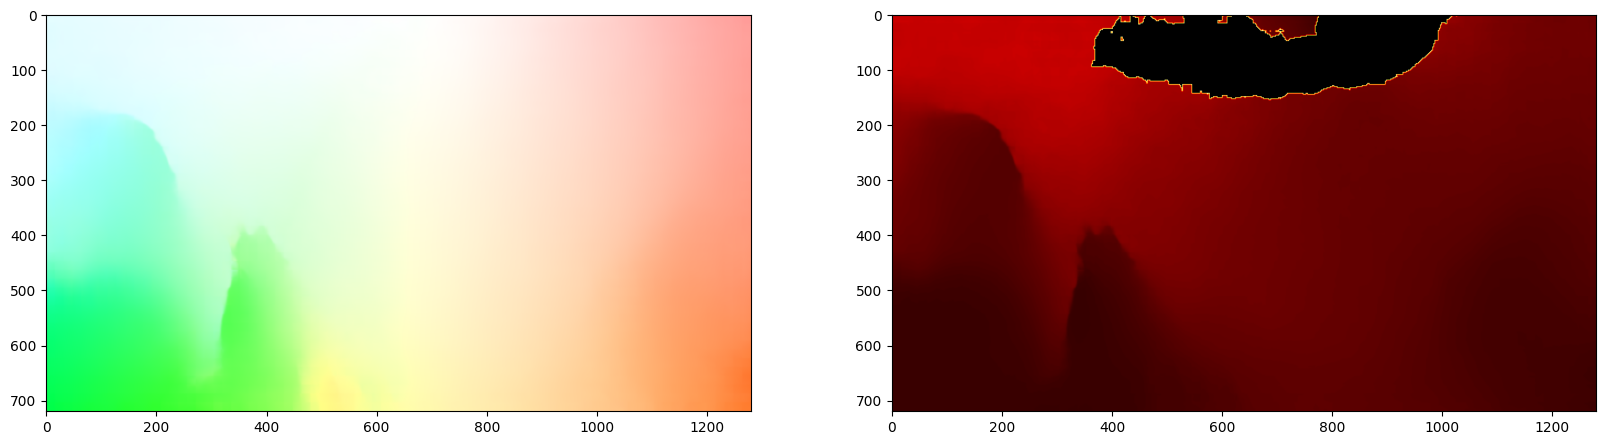

In [46]:
np.random.seed(43)
start = np.random.randint(0, len(video) - 1)
print(start)
slc = slice(start, start + 1)
r = representations["depth odoflow (raft)"]
y_flow_img = r.dependencies[0].make_images(slc, r.dependencies[0].make(slc), {})
y_dpt = r.make(slc)
y_dpt_img = r.make_images(slc, *y_dpt)
for i in range(len(y_dpt_img)):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(y_flow_img[i])
    ax[1].imshow(y_dpt_img[i])
